<a href="https://colab.research.google.com/github/sznajder/CSC2026/blob/main/JetTagging_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Jet Tagging **DeepSets**

---
In this notebook, we perform a Jet identification task using a DeepSets multiclass classifier.
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top.
We will represent each jet as a point cloud (or a "particle cloud") which consiststs of unordered set of jet's consistuent particles. Such a particle cloud representation of jets is efficient in incorporating raw information of jets and also explicitly respects the permutation symmetry.

Based on https://github.com/jngadiub/ML_course_Pavia_23

Modified by: Andre Sznajder

---

In [1]:
import os
import h5py
import glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [2]:
if not os.path.exists("Data-MLtutorial/JetDataset"):
    print("Dataset not found locally. Downloading and extracting...")
    os.system("curl -L https://cernbox.cern.ch/s/Hixs6KpgPFH8MN9/download -o Data-MLtutorial.tar.gz")
    os.system("tar -zxvf Data-MLtutorial.tar.gz")
    os.remove("Data-MLtutorial.tar.gz")
else:
    print("Dataset already exists. Skipping download.")

os.system("ls -al Data-MLtutorial/JetDataset/")

Dataset already exists. Skipping download.
total 748016
drwxr-xr-x  11 sznajder  staff       352 14 Aug 08:34 .
drwxr-xr-x   4 sznajder  staff       128  2 May  2022 ..
-rw-r--r--@  1 sznajder  staff      6148 14 Aug 08:32 .DS_Store
-rw-r--r--   1 sznajder  staff  47813131  2 May  2022 jetImage_7_100p_0_10000.h5
-rw-r--r--   1 sznajder  staff  48014611  2 May  2022 jetImage_7_100p_10000_20000.h5
-rw-r--r--   1 sznajder  staff  47753684  2 May  2022 jetImage_7_100p_30000_40000.h5
-rw-r--r--   1 sznajder  staff  48176508  2 May  2022 jetImage_7_100p_40000_50000.h5
-rw-r--r--   1 sznajder  staff  47905139  2 May  2022 jetImage_7_100p_50000_60000.h5
-rw-r--r--   1 sznajder  staff  47812902  2 May  2022 jetImage_7_100p_60000_70000.h5
-rw-r--r--   1 sznajder  staff  47649314  2 May  2022 jetImage_7_100p_70000_80000.h5
-rw-r--r--   1 sznajder  staff  47830990  2 May  2022 jetImage_7_100p_80000_90000.h5


0

In [3]:
target = np.array([])
jetList = np.array([])
feat_names = dict()
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
first=0
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    #save particles/nodes features names and their indecies in a dictionary
    if first==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        feat_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
      first=1
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


## One-Hot Encoding

The ground truth is incorporated in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form
*  [1, 0, 0, 0, 0] for gluons
*  [0, 1, 0, 0, 0] for quarks
*  [0, 0, 1, 0, 0] for W
*  [0, 0, 0, 1, 0] for Z
*  [0, 0, 0, 0, 1] for top quarks

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems). These labels are the 'target' for our classification tasks. Let's convert it back to single-column encoding :


In [4]:
num_classes = 5
label_names= ["gluon", "quark", "W", "Z", "top"]

## Jet Constituents features

In [5]:
feat_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
feat_idx = [feat_names[name] for name in feat_to_consider]
jetList = jetList[:,:,feat_idx]
print('Particles/Nodes considered features : ',feat_to_consider)

Particles/Nodes considered features :  ['etarel', 'phirel', 'pt', 'e', 'ptrel', 'erel', 'deltaR']


## Prepare the train and test datasets

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
del jetList, target

(33500, 100, 7) (16500, 100, 7) (33500, 5) (16500, 5)
Jets shape :  (50000, 100, 7)
Target/Labels shape :  (50000, 5)


In [7]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [8]:
nnodes_phi = 32
nnodes_rho = 16
activ      = "relu"

# Input tensor shape
nconstit = X_train.shape[1]
nfeat = X_train.shape[2]


# Instantiate Tensorflow input tensors in Batch mode
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format


# Input point features BatchNormalization
h = BatchNormalization(name='BatchNorm')(inp)

# Phi MLP ( permutation equivariant layers )
h = Dense(nnodes_phi)(h)
h = Activation(activ)(h)
h = Dense(nnodes_phi)(h)
h = Activation(activ)(h)
h = Dense(nnodes_phi)(h)
phi_out = Activation(activ)(h)


# Agregate features (taking mean) over set elements
mean = GlobalAveragePooling1D(name='avgpool_1')(phi_out)      # return mean of features over jets constituents

# Rho MLP
h = Dense(nnodes_rho)(mean)
h = Activation(activ)(h)
h = Dense(num_classes)(h)
out = Activation('softmax',name='softmax_g')(h)

# Build the model
model = Model(inputs=inp, outputs=out)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.CategoricalAccuracy()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inp (InputLayer)                │ (None, 100, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm (BatchNormalization)  │ (None, 100, 7)         │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 32)        │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 32)        │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_1                       │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_g (Activation)          │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 2,995 (11.70 KB)

 Non-trainable params: 14 (56.00 B)

## Train the model

In [10]:
batch_size = 128
epochs = 50

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - categorical_accuracy: 0.3796 - loss: 1.3973 - val_categorical_accuracy: 0.3104 - val_loss: 1.4540
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5404 - loss: 1.1410 - val_categorical_accuracy: 0.5848 - val_loss: 1.0605
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - categorical_accuracy: 0.5965 - loss: 1.0078 - val_categorical_accuracy: 0.6054 - val_loss: 0.9904
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - categorical_accuracy: 0.6133 - loss: 0.9745 - val_categorical_accuracy: 0.6343 - val_loss: 0.9510
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.6307 - loss: 0.9516 - val_categorical_accuracy: 0.6313 - val_loss: 0.9476
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.6355 - loss: 0.9405 - val_categorical_accuracy: 0.6528 - val_loss: 0.9218
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.6381 - los

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


/tmp/ipykernel_10564/870046722.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


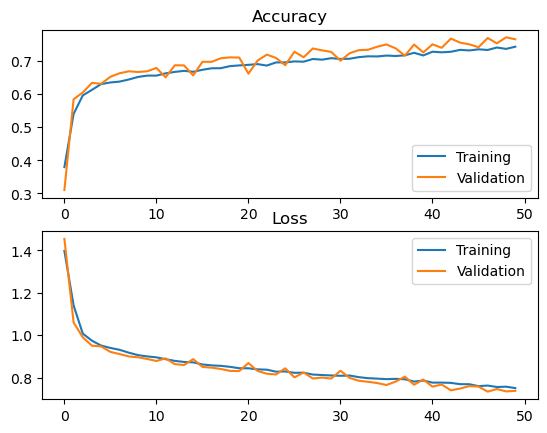

In [11]:
fig,axes = plt.subplots(2)
print(history.history.keys())
axes[0].plot(history.history["categorical_accuracy"])
axes[0].plot(history.history["val_categorical_accuracy"])
axes[0].set_title("Accuracy")
axes[0].legend(["Training", "Validation"])

axes[1].plot(history.history["loss"])
axes[1].plot(history.history["val_loss"])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss")

fig.show()



# Building the ROC Curves

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


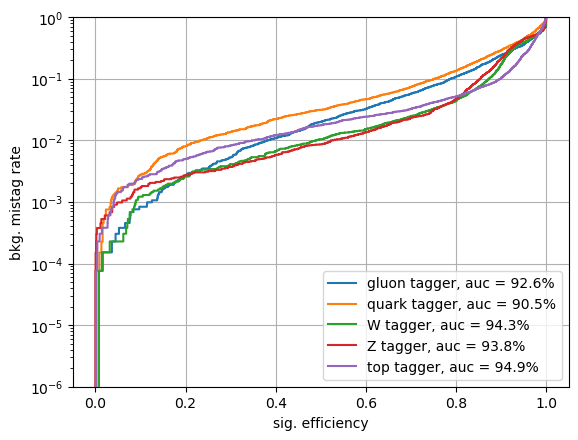

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(label_names):

        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()